In [ ]:
import os
import argparse
import torch
from torch.utils.data import DataLoader
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, Sampler

In [ ]:
import torch
import torch.nn as nn

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()

        self.relu = nn.ReLU()

        # Down-sampling convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        # Up-sampling convolution layers
        self.up1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.up2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.up3 = ConvLayer(32, 3, kernel_size=9, stride=1)

    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.up1(y)))
        y = self.relu(self.in5(self.up2(y)))
        return self.up3(y)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, padding_mode='reflect')

    def forward(self, x):
        return self.conv2d(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        return out + residual

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(UpsampleConvLayer, self).__init__()
        self.upsampling_factor = stride
        self.conv2d = ConvLayer(in_channels, out_channels, kernel_size, stride=1)

    def forward(self, x):
        if self.upsampling_factor > 1:
            x = nn.functional.interpolate(x, scale_factor=self.upsampling_factor, mode='nearest')
        return self.conv2d(x)

# # Function to initialize and load the TransformerNet model
# def load_transformer_net():
#     model = TransformerNet()
#     model.eval()
#     return model

# # Example of using the model
# if __name__ == '__main__':
#     model = load_transformer_net()
#     input_image = torch.randn(1, 3, 256, 256)  # Example input
#     output_image = model(input_image)
#     print(output_image.shape)


In [ ]:
def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

# print(gram_matrix(torch.randn(4, 3, 256, 256)).shape)

In [ ]:
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406])
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225])
IMAGENET_MEAN_255 = IMAGENET_MEAN_1 * 255
IMAGENET_STD_NEUTRAL = np.array([1, 1, 1])

In [ ]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # Convert BGR (opencv format) into RGB

    if target_shape is not None:  # Resize section
        if isinstance(target_shape, int) and target_shape != -1:  # Scalar -> implicitly setting the width
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # Set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    img = img.astype(np.float32)  # Convert from uint8 to float32
    img /= 255.0  # Get to [0, 1] range
    return img

In [ ]:
def post_process_image(dump_img):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy image got {type(dump_img)}'
    mean = IMAGENET_MEAN_1.reshape(1, 1, -1)  # Add new axis
    std = IMAGENET_STD_1.reshape(1, 1, -1)  # Add new axis
    dump_img = (dump_img * std) + mean  # De-normalize
    dump_img = (np.clip(dump_img, 0., 1.) * 255).astype(np.uint8)
    dump_img = np.moveaxis(dump_img, 0, 2)  # Move color channels to the last dimension
    return dump_img

In [ ]:
def save_and_maybe_display_image(dump_img, img_name, output_dir, should_display):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'
    dump_img = post_process_image(dump_img)
    # print(dump_img.shape)
    dump_img = dump_img.transpose(0,2,1)  # Move channels dimension to the last position
    dump_img = cv.rotate(dump_img, cv.ROTATE_90_CLOCKWISE)
    # print(dump_img.shape)
    assert dump_img.shape[2] == 3, f'Expected 3 channels, got {dump_img.shape[2]}'
    assert dump_img.dtype == np.uint8, f'Expected uint8 dtype, got {dump_img.dtype}'
    os.makedirs(output_dir, exist_ok=True)
    cv.imwrite(os.path.join(output_dir, img_name), dump_img[:, :, ::-1])  # ::-1 because opencv expects BGR (and not RGB) format...
    if should_display:
        print(dump_img.shape)
        print(dump_img.dtype)
        print(dump_img)
        plt.imshow(dump_img)
        plt.show()

In [ ]:
def prepare_img(img_path, target_shape, device, should_normalize=True, is_255_range=False):
    img = load_image(img_path, target_shape=target_shape)
    transform_list = [transforms.ToTensor()]
    if is_255_range:
        transform_list.append(transforms.Lambda(lambda x: x.mul(255)))
    if should_normalize:
        transform_list.append(transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL) if is_255_range else transforms.Normalize(mean=IMAGENET_MEAN_1, std=IMAGENET_STD_1))
    transform = transforms.Compose(transform_list)
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    return img

In [ ]:
def stylize_static_image(content_img_path, model_path, output_dir, target_width=None, should_display=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    stylization_model = TransformerNet().to(device)
    training_state = torch.load(model_path)
    state_dict = training_state["state_dict"]
    stylization_model.load_state_dict(state_dict, strict=True)
    stylization_model.eval()

    if target_width:
        img = load_image(content_img_path)
        h, w = img.shape[:2]
        target_height = int(h * (target_width / w))
        target_shape = (target_height, target_width)
    else:
        target_shape = None

    content_image = prepare_img(content_img_path, target_shape, device)

    with torch.no_grad():
        stylized_img = stylization_model(content_image).cpu().squeeze().permute(1, 2, 0).numpy()

    img_name = os.path.basename(content_img_path).split('.')[0] + '_stylized.jpg'
    save_and_maybe_display_image(stylized_img, img_name, output_dir, should_display)

In [ ]:
import cv2 as cv
import numpy as np

def color_transfer(source, target):
    # Convert images to LAB color space
    source_lab = cv.cvtColor(source, cv.COLOR_RGB2LAB).astype(np.float32)
    target_lab = cv.cvtColor(target, cv.COLOR_RGB2LAB).astype(np.float32)

    # Compute mean and standard deviation of each channel
    source_mean, source_std = np.mean(source_lab, axis=(0, 1)), np.std(source_lab, axis=(0, 1))
    target_mean, target_std = np.mean(target_lab, axis=(0, 1)), np.std(target_lab, axis=(0, 1))

    # Perform color transfer by matching histograms in LAB space
    for i in range(3):  # Iterate over channels (L, A, B)
        target_lab[:, :, i] = (target_lab[:, :, i] - target_mean[i]) / target_std[i] * source_std[i] + source_mean[i]

    # Clip values to valid range and convert back to RGB
    target_lab = np.clip(target_lab, 0, 255).astype(np.uint8)
    result = cv.cvtColor(target_lab, cv.COLOR_LAB2RGB)

    return result


(720, 1080, 3)
uint8
[[[ 95 159 100]
  [107 149  90]
  [ 92 150  89]
  ...
  [ 44 123  20]
  [ 57 157  74]
  [  6 140   0]]

 [[229 160 245]
  [252 156 249]
  [244 156 250]
  ...
  [247  80 224]
  [255 132 255]
  [200 107 160]]

 [[195 186 201]
  [216 180 206]
  [209 182 211]
  ...
  [182 139 156]
  [198 183 214]
  [130 159  79]]

 ...

 [[175 195 183]
  [196 184 185]
  [176 188 189]
  ...
  [127 179 139]
  [119 185 142]
  [ 99 186 102]]

 [[192 186 182]
  [217 173 178]
  [204 172 181]
  ...
  [208 135 118]
  [197 140 121]
  [181 144  85]]

 [[172 196 182]
  [195 186 187]
  [181 186 196]
  ...
  [130 176 149]
  [123 181 156]
  [106 182 114]]]


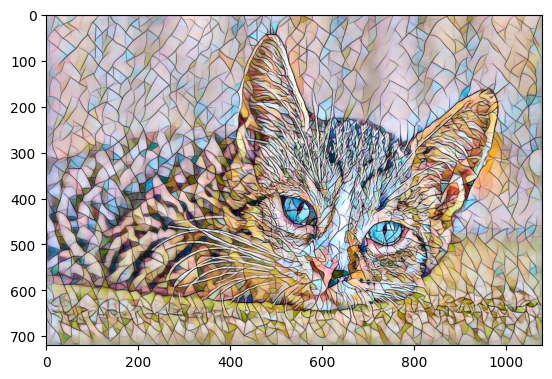

In [ ]:
content_img_path = '/content/cat.jpg'  # Replace with your image path
model_path = '/content/mosaic_4e5_e2.pth'  # Replace with your model path
output_dir = 'output_images'
target_width = 1080  # Set to None if you don't want to resize

stylize_static_image(content_img_path, model_path, output_dir, target_width, should_display=True)